Liz Rightmire

N1 Health Challenge

November 2024

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import geopandas as gpd
import geodatasets
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Data

In [2]:
cities = pd.read_csv("Datasets/500cities/500cities.csv")
# Split the 'Place_TractID' column on the hyphen and take the first 5 digits of the second part
cities['County_FIPS'] = cities['Place_TractID'].str.split('-').str[1].str[:5]
# Remove rows where 'County_FIPS' is NaN
cities = cities.dropna(subset=['County_FIPS'])

# Convert 'County_FIPS' to an integer
cities['County_FIPS'] = cities['County_FIPS'].astype(int)
cities.head()

,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Population2010,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,...,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation,County_FIPS
0,AL,Birmingham,107000,1073000100,0107000-01073000100,3042,24.4,"(21.2, 27.8)",31.2,"(30.1, 32.2)",...,20.5,"(18.9, 22.2)",45.5,"(44.3, 46.5)",5.5,"( 5.0, 5.9)",28.9,"(23.7, 35.1)","(33.57943283260, -86.7228323926)",1073
1,AL,Birmingham,107000,1073000300,0107000-01073000300,2735,30.4,"(27.1, 33.7)",30.5,"(29.3, 31.7)",...,22.2,"(20.4, 24.0)",44.5,"(43.2, 45.7)",6.1,"( 5.5, 6.8)",32.9,"(25.5, 40.2)","(33.54282086860, -86.7524339780)",1073
2,AL,Birmingham,107000,1073000400,0107000-01073000400,3338,24.7,"(21.1, 28.5)",31.5,"(30.2, 32.9)",...,19.4,"(17.5, 21.4)",45.7,"(44.2, 47.0)",5.6,"( 5.0, 6.2)",28.6,"(22.0, 35.1)","(33.56324496330, -86.7640474064)",1073
3,AL,Birmingham,107000,1073000500,0107000-01073000500,2864,25.2,"(21.6, 29.0)",35.0,"(33.5, 36.4)",...,21.7,"(19.7, 23.9)",46.1,"(44.5, 47.4)",7.3,"( 6.5, 8.2)",34.0,"(24.4, 42.9)","(33.54424045940, -86.7749130719)",1073
4,AL,Birmingham,107000,1073000700,0107000-01073000700,2577,29.0,"(24.5, 33.8)",36.3,"(34.9, 37.7)",...,25.5,"(23.1, 28.0)",48.3,"(46.6, 49.7)",9.0,"( 8.1, 10.0)",43.2,"(33.2, 53.2)","(33.55254061390, -86.8016893706)",1073


In [3]:
populations = pd.read_csv("Datasets/FoodEnvironmentAtlas/SupplementalDataCounty.csv")
populations.head()

,FIPS,State,County,Variable_Code,Value
0,1001,AL,Autauga County,2010_Census_Population,54571
1,1001,AL,Autauga County,Population_Estimate_2011,55208
2,1001,AL,Autauga County,Population_Estimate_2012,54936
3,1001,AL,Autauga County,Population_Estimate_2013,54713
4,1001,AL,Autauga County,Population_Estimate_2014,54876


In [4]:
access = pd.read_csv("Datasets/FoodEnvironmentAtlas/access.csv")
access

,FIPS,State,County,LACCESS_POP10,LACCESS_POP15,PCH_LACCESS_POP_10_15,PCT_LACCESS_POP10,PCT_LACCESS_POP15,LACCESS_LOWI10,LACCESS_LOWI15,...,LACCESS_HISP15,PCT_LACCESS_HISP15,LACCESS_NHASIAN15,PCT_LACCESS_NHASIAN15,LACCESS_NHNA15,PCT_LACCESS_NHNA15,LACCESS_NHPI15,PCT_LACCESS_NHPI15,LACCESS_MULTIR15,PCT_LACCESS_MULTIR15
0,1001,AL,Autauga,18428.439690,17496.693040,-5.056026,33.769657,32.062255,5344.427472,6543.676824,...,471.136164,0.863345,86.767975,0.159000,61.169869,0.112092,8.817961,0.016159,482.848633,0.884808
1,1003,AL,Baldwin,35210.814080,30561.264430,-13.204891,19.318473,16.767489,9952.144027,9886.831137,...,1377.874834,0.755973,212.946378,0.116833,181.649648,0.099662,14.819634,0.008131,1127.696098,0.618712
2,1005,AL,Barbour,5722.305602,6069.523628,6.067799,20.840972,22.105560,3135.676086,2948.790251,...,509.377525,1.855183,17.096410,0.062266,39.960527,0.145539,8.082376,0.029436,462.382655,1.684025
3,1007,AL,Bibb,1044.867327,969.378841,-7.224696,4.559753,4.230324,491.449066,596.162829,...,8.596762,0.037516,1.994318,0.008703,2.513097,0.010967,0.000000,0.000000,5.259244,0.022951
4,1009,AL,Blount,1548.175559,3724.428242,140.568857,2.700840,6.497380,609.027708,1650.959482,...,497.489891,0.867886,8.428994,0.014705,28.938242,0.050484,1.062851,0.001854,202.914186,0.353990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,56037,WY,Sweetwater,13391.715500,18934.737810,41.391428,30.570505,43.224074,2414.618816,4750.905615,...,2661.350520,6.075311,114.722086,0.261887,189.621441,0.432866,27.720443,0.063280,1605.391465,3.664775
3139,56039,WY,Teton,6212.423697,6212.390430,-0.000535,29.174527,29.174370,1059.463554,1577.771012,...,736.174507,3.457192,53.489780,0.251196,32.482255,0.152542,8.468847,0.039771,460.434464,2.162273
3140,56041,WY,Uinta,4270.147119,4686.017653,9.739021,20.220414,22.189685,1518.415783,2054.179828,...,535.616715,2.536304,13.831709,0.065497,40.339658,0.191020,6.586104,0.031187,350.320469,1.658871
3141,56043,WY,Washakie,931.411647,931.411647,0.000000,10.915407,10.915407,233.628356,309.030331,...,35.474502,0.415733,6.366775,0.074614,5.006976,0.058678,0.000000,0.000000,34.160542,0.400334


In [5]:
insecurity = pd.read_csv("Datasets/FoodEnvironmentAtlas/insecurity.csv")
insecurity

,FIPS,State,County,FOODINSEC_12_14,FOODINSEC_15_17,CH_FOODINSEC_14_17,VLFOODSEC_12_14,VLFOODSEC_15_17,CH_VLFOODSEC_14_17,Unnamed: 9
0,1001,AL,Autauga,16.8,16.3,-0.5,7.2,7.1,-0.1,NaN
1,1003,AL,Baldwin,16.8,16.3,-0.5,7.2,7.1,-0.1,NaN
2,1005,AL,Barbour,16.8,16.3,-0.5,7.2,7.1,-0.1,NaN
3,1007,AL,Bibb,16.8,16.3,-0.5,7.2,7.1,-0.1,NaN
4,1009,AL,Blount,16.8,16.3,-0.5,7.2,7.1,-0.1,NaN
...,...,...,...,...,...,...,...,...,...,...
3138,56037,WY,Sweetwater,14.0,13.2,-0.8,5.3,5.1,-0.2,NaN
3139,56039,WY,Teton,14.0,13.2,-0.8,5.3,5.1,-0.2,NaN
3140,56041,WY,Uinta,14.0,13.2,-0.8,5.3,5.1,-0.2,NaN
3141,56043,WY,Washakie,14.0,13.2,-0.8,5.3,5.1,-0.2,NaN


In [6]:
stores = pd.read_csv("Datasets/FoodEnvironmentAtlas/stores.csv")
stores

,FIPS,State,County,GROC11,GROC16,PCH_GROC_11_16,GROCPTH11,GROCPTH16,PCH_GROCPTH_11_16,SUPERC11,...,PCH_SNAPS_12_17,SNAPSPTH12,SNAPSPTH17,PCH_SNAPSPTH_12_17,WICS11,WICS16,PCH_WICS_11_16,WICSPTH11,WICSPTH16,PCH_WICSPTH_11_16
0,1001,AL,Autauga,5,3,-40.000000,0.090581,0.054271,-40.085748,1,...,19.376392,0.674004,0.804747,19.397900,5.0,5.0,0.000000,0.090567,0.090511,-0.061543
1,1003,AL,Baldwin,27,29,7.407407,0.144746,0.139753,-3.449328,6,...,36.927711,0.725055,0.890836,22.864524,26.0,28.0,7.692307,0.139380,0.134802,-3.284727
2,1005,AL,Barbour,6,4,-33.333333,0.219370,0.155195,-29.254287,0,...,3.349282,1.280590,1.424614,11.246689,7.0,6.0,-14.285714,0.255942,0.232387,-9.203081
3,1007,AL,Bibb,6,5,-16.666667,0.263794,0.220916,-16.254289,1,...,11.794872,0.719122,0.801423,11.444711,6.0,5.0,-16.666666,0.263771,0.221474,-16.035471
4,1009,AL,Blount,7,5,-28.571429,0.121608,0.086863,-28.571429,1,...,5.701754,0.657144,0.692374,5.361034,8.0,8.0,0.000000,0.139000,0.139089,0.064332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,56037,WY,Sweetwater,5,4,-20.000000,0.113603,0.090406,-20.419482,1,...,40.343348,0.428936,0.625948,45.930131,4.0,4.0,0.000000,0.090948,0.090344,-0.664035
3139,56039,WY,Teton,5,11,120.000000,0.232818,0.474547,103.827437,0,...,52.380952,0.242215,0.343864,41.966780,3.0,3.0,0.000000,0.140095,0.129528,-7.542849
3140,56041,WY,Uinta,3,2,-33.333333,0.143548,0.096567,-32.728180,1,...,30.714286,0.554895,0.744084,34.094553,3.0,3.0,0.000000,0.143589,0.144991,0.976268
3141,56043,WY,Washakie,2,2,0.000000,0.236407,0.244260,3.321935,0,...,7.352941,0.669502,0.754382,12.677988,2.0,2.0,0.000000,0.236742,0.244858,3.428013


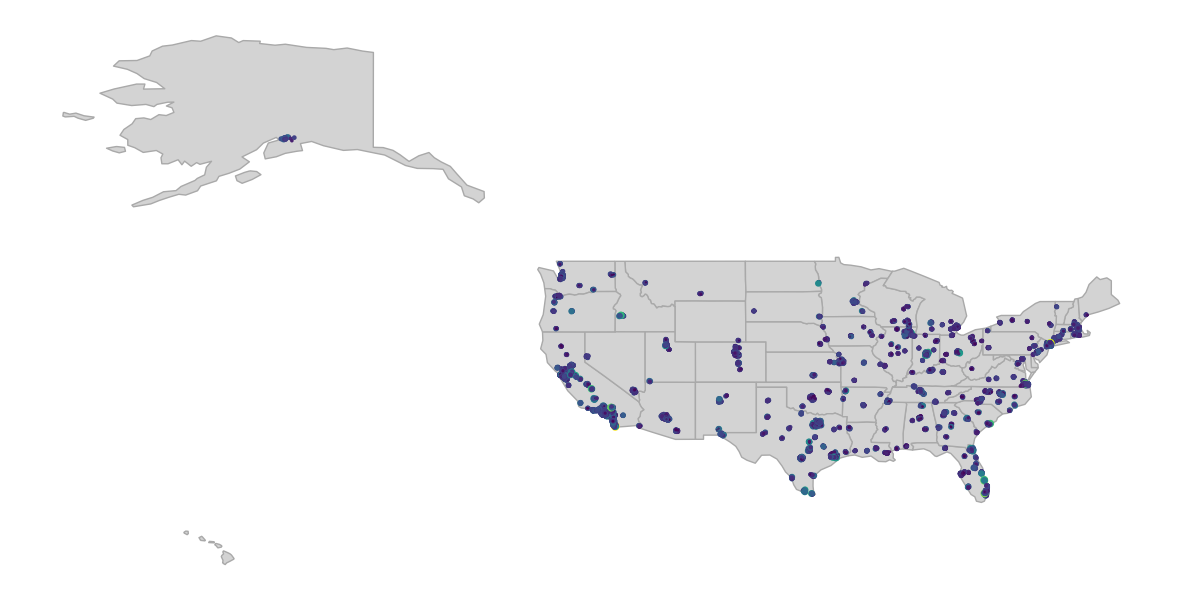

In [7]:
# Clean and preprocess Geolocation
cities['Geolocation'] = cities['Geolocation'].str.strip("()")
cities['Geolocation'] = cities['Geolocation'].apply(lambda x: tuple(map(float, x.split(", "))))
cities['latitude'] = cities['Geolocation'].apply(lambda x: x[0])
cities['longitude'] = cities['Geolocation'].apply(lambda x: x[1])

# Create Point geometry
cities['geometry'] = cities.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Load the dataset
states = gpd.read_file("states/states.shp")

# Convert cities DataFrame into a GeoDataFrame
gdf = gpd.GeoDataFrame(cities, geometry='geometry')

# Plot the USA map and overlay the population data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot USA boundaries
states.plot(ax=ax, color='lightgray', edgecolor='darkgrey')

# Overlay the cities data
gdf.plot(column='Population2010', 
         cmap='viridis', 
         legend=False, 
         ax=ax,
         markersize=gdf['Population2010'] / 1000)  # Adjust marker size by population

# Customize the plot
plt.axis("off")  # Hide axes
plt.show()

In [8]:
#print(cities['Geolocation'].head())
#print(cities['Geolocation'].dtype)

simple map

<Axes: >

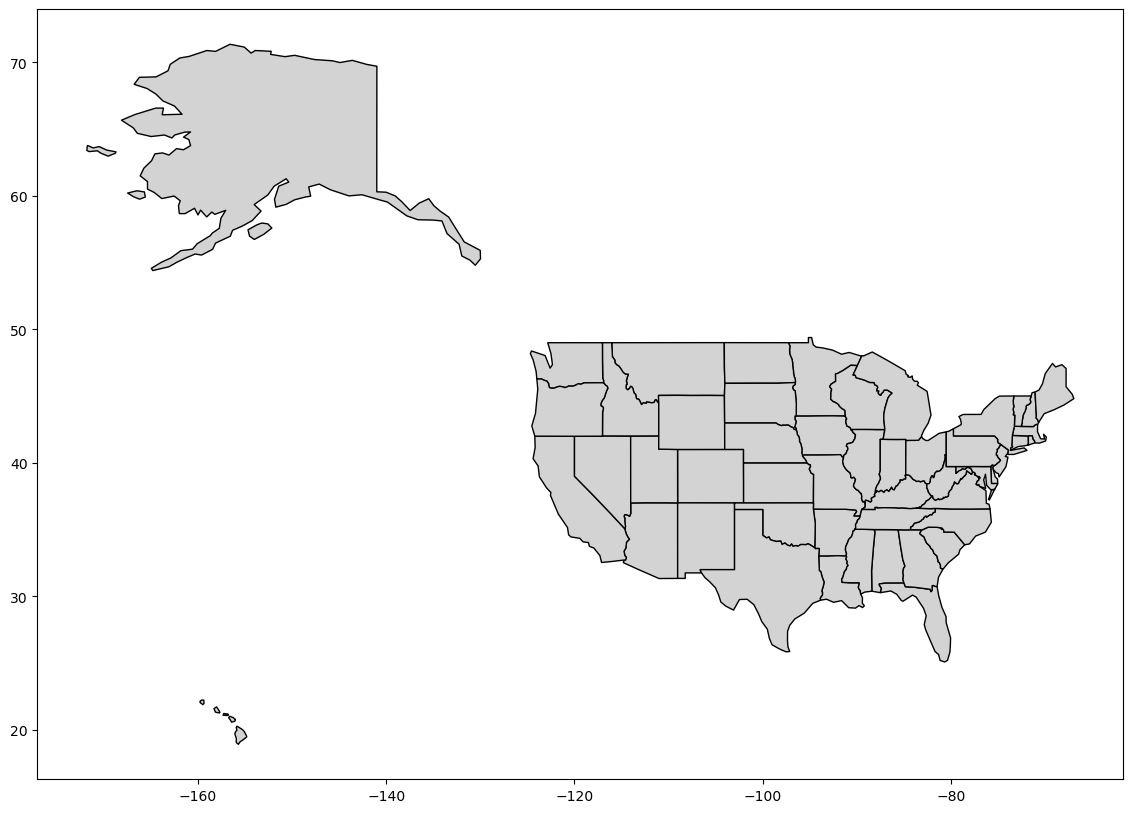

In [9]:
import geopandas as gpd 

# Load the dataset
states = gpd.read_file("states/states.shp")

# Plot the USA map and overlay the population data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot USA boundaries
states.plot(ax=ax, color='lightgray', edgecolor='black')

Merged

In [10]:
# select columns from cities
cities_filtered = cities[['County_FIPS', 'PlaceName', 'Geolocation']]
#cities_filtered = cities_filtered.drop_duplicates(subset=['County_FIPS', 'PlaceName'])


# select columns from access
access_filtered = access[["FIPS", "County", "PCT_LACCESS_LOWI15", "PCT_LACCESS_HHNV15"]]

# Merge the cities DataFrame with the Food Atlas DataFrame on FIPS
merged_data = pd.merge(cities_filtered, access_filtered, 
                       left_on= "County_FIPS", 
                       right_on = "FIPS",
                       how="inner")

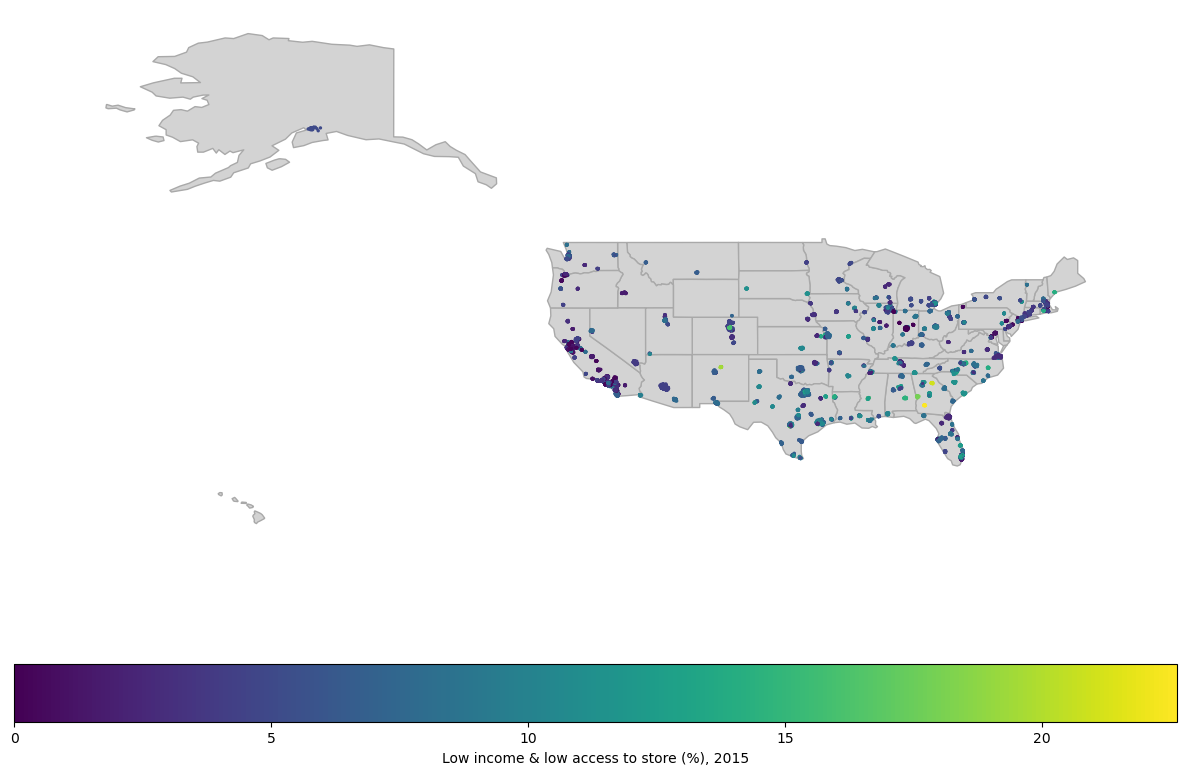

In [11]:
# Clean and preprocess Geolocation
#cities['Geolocation'] = cities['Geolocation'].str.strip("()")
#cities['Geolocation'] = cities['Geolocation'].apply(lambda x: tuple(map(float, x.split(", "))))
#cities['latitude'] = cities['Geolocation'].apply(lambda x: x[0])
#cities['longitude'] = cities['Geolocation'].apply(lambda x: x[1])

# Load the dataset
#states = gpd.read_file("states/states.shp")

# Create Point geometry
merged_data['geometry'] = cities.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Convert cities DataFrame into a GeoDataFrame
gdf = gpd.GeoDataFrame(merged_data, geometry='geometry')

# Plot the USA map and overlay the population data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot USA boundaries
states.plot(ax=ax, color='lightgray', edgecolor='darkgrey')

# Overlay the cities data
gdf.plot(column='PCT_LACCESS_LOWI15', 
         cmap='viridis', 
         legend=True, 
         legend_kwds={'label': 'Low income & low access to store (%), 2015', 'orientation': 'horizontal'},
         ax=ax, 
         markersize=2)

# Customize the plot
plt.axis("off")
plt.show()

In [14]:
# Load shapefile of U.S. counties
#gdf = gpd.read_file('Datasets/counties/tl_2024_us_county.shp')

# Calculate centroids for each county
#gdf['centroid'] = gdf.geometry.centroid

Priority List

In [13]:
# big merge
merged_atlas = pd.merge(access[["FIPS",  "State", "County", "PCT_LACCESS_LOWI15", "PCT_LACCESS_HHNV15"]], 
                        insecurity[["FIPS", "FOODINSEC_15_17", "VLFOODSEC_15_17"]],
                       on= "FIPS", 
                       how="inner")

merged_atlas

,FIPS,State,County,PCT_LACCESS_LOWI15,PCT_LACCESS_HHNV15,FOODINSEC_15_17,VLFOODSEC_15_17
0,1001,AL,Autauga,11.991125,3.351332,16.3,7.1
1,1003,AL,Baldwin,5.424427,1.905114,16.3,7.1
2,1005,AL,Barbour,10.739667,4.329378,16.3,7.1
3,1007,AL,Bibb,2.601627,2.821427,16.3,7.1
4,1009,AL,Blount,2.880150,3.336414,16.3,7.1
...,...,...,...,...,...,...,...
3138,56037,WY,Sweetwater,10.845331,2.182752,13.2,5.1
3139,56039,WY,Teton,7.409463,0.540222,13.2,5.1
3140,56041,WY,Uinta,9.727151,2.759922,13.2,5.1
3141,56043,WY,Washakie,3.621591,1.203633,13.2,5.1


In [16]:
# Sort the DataFrame by 'food_insec' in descending order and get the top 20 counties
top_20_insecurity = merged_atlas.sort_values(by='VLFOODSEC_15_17', ascending=False).head(20)

# Display the top 20 counties
print(top_20_insecurity)

       FIPS State                County  PCT_LACCESS_LOWI15  \
0      1001    AL               Autauga           11.991125   
1162  22099    LA            St. Martin            1.664862   
1148  22071    LA               Orleans            8.852439   
1149  22073    LA              Ouachita           13.829474   
1150  22075    LA           Plaquemines           11.897779   
1151  22077    LA         Pointe Coupee            5.986719   
1152  22079    LA               Rapides           15.691909   
1153  22081    LA             Red River            9.170981   
1154  22083    LA              Richland            6.419158   
1155  22085    LA                Sabine           12.101744   
1156  22087    LA           St. Bernard           19.183186   
1157  22089    LA           St. Charles           18.259066   
1158  22091    LA            St. Helena            3.468194   
1159  22093    LA             St. James            9.649594   
1160  22095    LA  St. John the Baptist           12.94